imports

In [238]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


Read predicted results per constituency

In [239]:
prior=pd.read_csv("electdata_pred.txt", sep=";",encoding='latin1', usecols=["Name", "Electorate", "CON", "LAB", "LIB", "Reform", "Green", "OTH", "NAT", "MIN"])
prior['OTH'] = prior['OTH'] + prior['NAT'] + prior['MIN']


prior.drop(['NAT', 'MIN'], axis=1, inplace=True)
prior.head()

,Name,Electorate,CON,LAB,LIB,Reform,Green,OTH
0,Aldershot,72617,13010,13928,5413,6264,2337,549
1,Aldridge-Brownhills,60138,13768,10240,2951,5469,1369,0
2,Altrincham and Sale West,73107,11867,19689,4833,8328,4154,0
3,Amber Valley,69976,11128,16025,2084,7022,2643,0
4,Arundel and South Downs,81726,16589,11379,12326,9569,5097,439


plot function

In [240]:
from matplotlib import pyplot
def plot_series(time_series):
    values = time_series.values
    # specify columns to plot
    groups = [0, 1, 2, 3, 4, 5]
    i = 1
    pyplot.figure()
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(time_series.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

a region classifier

In [241]:
def region_classifier(pcon):
    lad_to_region=pd.read_csv("Local_Authority_District_to_Region_(December_2022)_Lookup_in_England.csv", usecols=["LAD22CD", "RGN22CD"])
    pcon_to_lad=pd.read_csv("Ward_to_Westminster_Parliamentary_Constituency_to_Local_Authority_District_to_Upper_Tier_Local_Authority_(December_2022)_Lookup_in_the_United_Kingdom.csv", 
                            usecols=["PCON22NM", "LAD22CD"])

    lad=pcon_to_lad[pcon_to_lad["PCON22NM"]==pcon]
    if lad.empty:
        print(f"No LAD found for {pcon}")
        return
    lad=lad["LAD22CD"].values[0]
    region=lad_to_region[lad_to_region["LAD22CD"]==lad]
    if region.empty:
        print(f"No region found for {pcon}")
        return
    region=region["RGN22CD"].values[0]
    if region[0]=="S":
        region="Scotland"
    elif region[0]=="W":
        region="Wales"
    elif region[0]=="N":
        print("No data for Northern Ireland")
    else:
        last=int(region[-1])
        if last==7:
            region="London"
        elif last in [1,2,3]:
            region="North"
        elif last in [4,5]:
            region="Midlands"
        elif last in [6, 8, 9]:
            region="Rest of South"
    return(region)



age range classifier

In [ ]:
def age_range(age):
    switch = {
        18 <= age <= 24: "18-24",
        25 <= age <= 49: "25-49",
        50 <= age <= 64: "50-64",
        age > 64: "65+"
    }

    
    for condition, output in switch.items():
        if condition:
            return output

   
    print("Not a valid age")


standardize function

In [242]:
def standardize(array):
    sum=0
    for i in array:
        sum+=i
    return array/sum


create dataset function based on location, gender and age

In [243]:
def create_dataset(constituency, gender, age):
    
    result2019=prior[prior["Name"]==constituency]
    loc_time_series=pd.read_excel("poll.xlsx", sheet_name=region_classifier(constituency), skiprows=[9,10], index_col=[0]).T
    loc_time_series['Other'] = loc_time_series['Other'] + loc_time_series['SNP'] + loc_time_series['Plaid Cymru']
    loc_time_series.drop(['SNP', 'Plaid Cymru'], axis=1, inplace=True)
    gender_time_series=pd.read_excel("poll.xlsx", sheet_name=gender, skiprows=[9,10], index_col=[0]).T
    gender_time_series['Other'] = gender_time_series['Other'] + gender_time_series['SNP'] + gender_time_series['Plaid Cymru']
    gender_time_series.drop(['SNP', 'Plaid Cymru'], axis=1, inplace=True)
    age_time_series=pd.read_excel("poll.xlsx", sheet_name=age_range(age), skiprows=[9,10], index_col=[0]).T
    age_time_series['Other'] = age_time_series['Other'] + age_time_series['SNP'] + age_time_series['Plaid Cymru']
    age_time_series.drop(['SNP', 'Plaid Cymru'], axis=1, inplace=True)
    
    prior_prob= prior[prior["Name"]==constituency].values
    
    return result2019, loc_time_series, gender_time_series, age_time_series, prior_prob

result2019, loc_time_series, gender_time_series, age_time_series, prior_prob = create_dataset("Leyton and Wanstead", "Male", 20)
print(loc_time_series.head())
print(loc_time_series.columns)
prior_prob=prior_prob.flatten()
prior_prob=standardize(prior_prob[2:])
print(prior_prob)


Date         Con   Lab  Lib Dem  Reform UK  Green  Other
2020-01-26  0.35  0.48     0.10       0.01   0.06    0.0
2020-02-02  0.34  0.43     0.17       0.02   0.04    0.0
2020-02-10  0.36  0.40     0.13       0.01   0.10    0.0
2020-04-02  0.37  0.45     0.10       0.01   0.07    0.0
2020-04-17  0.41  0.47     0.08       0.00   0.04    0.0
Index(['Con', 'Lab', 'Lib Dem', 'Reform UK', 'Green', 'Other'], dtype='object', name='Date')
[0.06359843897187457 0.6711344368187323 0.05326335621046965
 0.12999596285829632 0.07019243708787512 0.011815368052751985]


plots

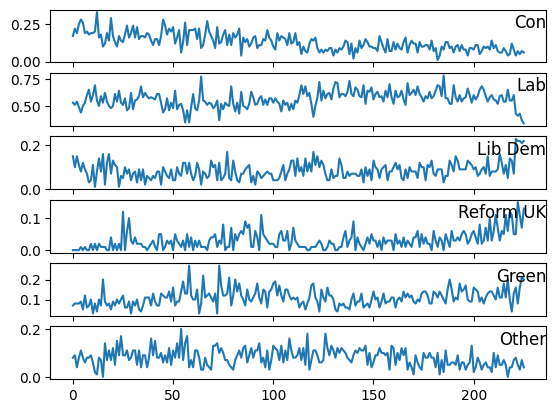

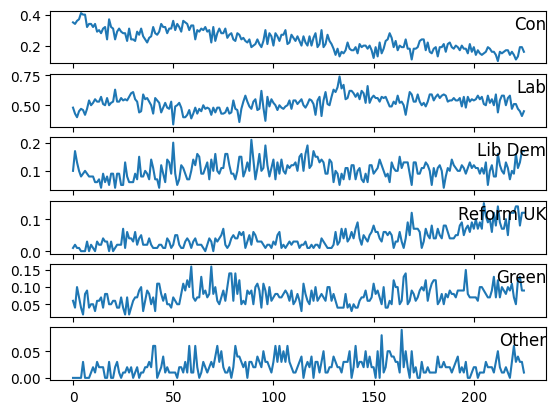

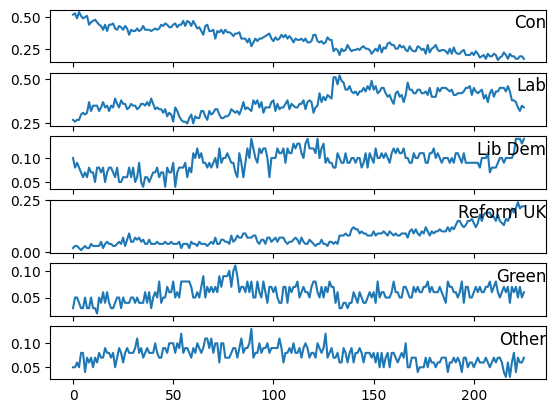

In [244]:

plot_series(age_time_series)
plot_series(loc_time_series)
plot_series(gender_time_series)

fitting a model

In [245]:
def split_dataset(data):
	split_index = int(len(data) * 0.75) 
	train, test = data.iloc[:split_index], data.iloc[split_index:]
	return train, test
train, test=split_dataset(age_time_series)

In [246]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import warnings
model = VAR(train)
model_fitted = model.fit()
lag_order = model_fitted.k_ar
forecast = model_fitted.forecast(train.values[-lag_order:], steps=len(test))
actual_values = test.values
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.")

mse = mean_squared_error(actual_values, forecast)
print(f"Test MSE: {mse}")

Test MSE: 0.0030465273463914123


C:\Users\jairo\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


this low MSE shows this is a good model to fit

now we will forecast 

In [247]:
forecast=[[] for _ in range(3)]
time_series_data = {
    'age': age_time_series,
    'gender': gender_time_series,
    'location': loc_time_series
}
i=0
for key, ts_data in time_series_data.items():
    # Fit VAR model
    model = VAR(ts_data)
    model_fitted = model.fit()
    
    # Get lag order
    lag_order = model_fitted.k_ar
    forecast[i] = standardize(np.array(model_fitted.forecast(ts_data.values[-lag_order:], steps=2)[1]))
    i+=1
    # Store fitted model and lag order
print(forecast)




[array([0.1004814 , 0.52092669, 0.11716297, 0.06075468, 0.13349424,
       0.06718002]), array([0.16631974, 0.37220524, 0.12391099, 0.19972597, 0.07485091,
       0.06298715]), array([0.17164506, 0.53222864, 0.11427473, 0.0762366 , 0.08126282,
       0.02435214])]


C:\Users\jairo\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jairo\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jairo\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


we will use bayes theorem to find the final probability

In [258]:
div=0

for i in range(len(loc_time_series.columns)):
    div+=prior_prob[i]*forecast[0][i]*forecast[1][i]*forecast[2][i]
print(div)
posterior_dict= {
    "Conservative": [prior_prob[0]*forecast[0][0]*forecast[1][0]*forecast[2][0]/div],
    "Labour": [prior_prob[1]*forecast[0][1]*forecast[1][1]*forecast[2][1]/div],
    "Liberal Democrat": [prior_prob[2]*forecast[0][2]*forecast[1][2]*forecast[2][2]/div],
    "Reform": [prior_prob[3]*forecast[0][3]*forecast[1][3]*forecast[2][3]/div],
    "Green": [prior_prob[4]*forecast[0][4]*forecast[1][4]*forecast[2][4]/div],
    "Other": [prior_prob[5]*forecast[0][5]*forecast[1][5]*forecast[2][5]/div]
}
posterior = pd.DataFrame(posterior_dict)

print(posterior)

0.06970677605878255
   Conservative    Labour  Liberal Democrat    Reform     Green     Other
0      0.002617  0.993555          0.001268  0.001725  0.000818  0.000017


function for finding most likely party to vote

In [259]:
def get_highest_probability_column(df):
    
    max_columns = df.iloc[0].idxmax()

    return max_columns
highest_prob_column = get_highest_probability_column(posterior)

print(highest_prob_column)

Labour
